In [2]:
%matplotlib inline

import copy
from datetime import date
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sys
import time
import torch as pt

sys.path.insert(0, '../..')

from function_space import Constant, Linear, DenseNet, NN, NN_Nik, SingleParam, MySequential
from problems import DoubleWell, DoubleWell_multidim, DoubleWell_OU, LQGC, LLGC, DoubleWell_multidim
from solver import Solver
from utilities import do_importance_sampling, do_importance_sampling_Wei, plot_control_for_DoubleWell1d, plot_loss_logs, plot_solution, save_exp_logs, load_exp_logs

%load_ext autoreload
%autoreload 2

device = pt.device('cuda')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
class DenseNet_2(pt.nn.Module):
    def __init__(self, d_in, d_out, lr, arch=[30, 30], seed=42):
        super(DenseNet_2, self).__init__()
        pt.manual_seed(seed)
        self.nn_dims = [d_in] + arch + [d_out]
        self.layers = pt.nn.ModuleList([pt.nn.Linear(sum(self.nn_dims[:i + 1]), self.nn_dims[i + 1])
                                        for i in range(len(self.nn_dims) - 1)])   
        self.optim = pt.optim.Adam(self.parameters(), lr=lr)
        self.relu = pt.nn.ReLU()

    def forward(self, x):
        for i in range(len(self.nn_dims) - 1):
            if i == len(self.nn_dims) - 2:
                x = self.layers[i](x)
            else:
                x = pt.cat([x, pt.nn.functional.tanh(self.layers[i](x))], dim=1)
        return x
    
class SingleParam(pt.nn.Module):
    def __init__(self, lr, initial=None, seed=42):
        super(SingleParam, self).__init__()
        pt.manual_seed(seed)
        if initial is None:
            self.Y_0 = pt.nn.Parameter(pt.tensor([0.0]), requires_grad=True)
        elif initial == 'random':
            self.Y_0 = pt.nn.Parameter(pt.randn(1), requires_grad=True)
        else:
            self.Y_0 = pt.nn.Parameter(pt.tensor([initial]), requires_grad=True)

        self.register_parameter('param', self.Y_0)
        self.optim = pt.optim.Adam(self.parameters(), lr=lr)
        #self.optim = pt.optim.SGD(self.parameters(), lr=lr)

    def forward(self, x):
        return self.Y_0
    
class DenseNet(pt.nn.Module):
    def __init__(self, d_in, d_out, lr, arch=[30, 30], seed=42):
        super(DenseNet, self).__init__()
        pt.manual_seed(seed)
        self.nn_dims = [d_in] + arch + [d_out]
        self.W = [item for sublist in
                  [[pt.nn.Parameter(pt.randn(sum(self.nn_dims[:i + 1]), self.nn_dims[i + 1],
                                             requires_grad=True) * 0.1),
                    pt.nn.Parameter(0.8 * pt.ones(self.nn_dims[i + 1], requires_grad=True))] for
                   i in range(len(self.nn_dims) - 1)]
                  for item in sublist]
        self.relu = pt.nn.ReLU()
        self.sigmoid = pt.nn.Sigmoid()

        for i, w in enumerate(self.W):
            self.register_parameter('param %d' % i, w)

        self.optim = pt.optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        for i in range(len(self.nn_dims) - 1):
            if i == len(self.nn_dims) - 2:
                x = pt.matmul(x, self.W[2 * i]) + self.W[2 * i + 1]
            else:
                x = pt.cat([x, pt.nn.functional.relu(pt.matmul(x, self.W[2 * i])
                                                     + self.W[2 * i + 1]) ** 2], dim=1)
        return pt.nn.functional.relu(x)

In [12]:
class Eigenvalue():
    def __init__(self, name='Eigenvalue', d=1):
        self.name = name
        self.d = d
        self.B = (pt.sqrt(pt.tensor(2.0)) * pt.eye(self.d)).to(device)
        self.c = 0.1 * pt.ones(1, d).to(device)
        self.X_0 = pt.tensor(np.pi) * pt.ones(self.d).to(device)
        self.Y_0 = pt.zeros(1).to(device)
        self.lambda_ = 0.0
        self.X_l = 0.0
        self.X_r = 2 * np.pi

    def b(self, x):
        return -pt.cos(pt.sum(self.c * pt.cos(x), 1)).unsqueeze(1) * self.c * pt.sin(x)

    def sigma(self, x):
        return self.B

    def g(self, x):
        #return pt.exp(self.alpha * pt.sqrt(pt.sum(x**2, 1)))
        return pt.zeros(x.shape[0]).to(device)

    def h(self, x, y, z):
        return y * (-pt.sum(self.c**2 * pt.sin(x)**2, 1) * pt.sin(pt.sum(self.c * pt.cos(x), 1))
                    - pt.cos(pt.sum(self.c * pt.cos(x), 1)) * pt.sum(self.c * pt.cos(x), 1))
   
    #def u_true(self, x):
    #    return -self.B * pt.tensor(np.pi) * pt.cos(pt.tensor(np.pi) * x)
   
    def v_true(self, x):
        #return pt.exp(self.alpha * pt.sqrt(pt.sum(x**2, 1)))
        return pt.exp(-pt.sin(pt.sum(self.c * pt.cos(x), 1)))

In [13]:
d = 5

problem = Eigenvalue(d=d)

V = DenseNet(d, 1, lr=0.001, arch=[10, 10, 10, 10]).to(device)
lambda_ = SingleParam(initial=0.5, lr=0.01).to(device)

In [34]:
alpha = [50.0, 1.0]

L = 100000
N = 20
K = 500
K_boundary = 50
print_every = 100
delta_t = pt.tensor([0.001]).to(device)
delta_t_np = delta_t.cpu().numpy()
sq_delta_t = pt.sqrt(delta_t)

adaptive_forward_process = False
detach_forward = True

loss_log = []
loss_log_boundary = []
loss_log_derivative_boundary = []
loss_log_domain = []
loss_log_center = []
V_L2_log = []
times = []
y_0_log = []
lambda_log = []

for l in range(L):

    t_0 = time.time()

    loss = 0

    X_center = problem.X_0.repeat(1, 1).to(device)
    loss += pt.mean((V(X_center).squeeze() - problem.v_true(X_center).squeeze())**2)
    
    loss_log_center.append(loss.item())

    # sample uniformly on boundary
    s = np.concatenate([np.ones(int(K_boundary / 2))[:, np.newaxis], np.zeros([int(K_boundary / 2), d - 1])], 1)
    np.apply_along_axis(np.random.shuffle, 1, s)
    a = np.concatenate([s, np.zeros([int(K_boundary / 2), problem.d])]).astype(bool)
    b = np.concatenate([np.zeros([int(K_boundary / 2), problem.d]), s]).astype(bool)
    X_boundary = (problem.X_r - problem.X_l) * pt.rand(K_boundary, problem.d).to(device) + problem.X_l
    X_boundary_reflect = copy.deepcopy(X_boundary)
    X_boundary[pt.tensor(a.astype(float)).bool()] = problem.X_l
    X_boundary_reflect[pt.tensor(a.astype(float)).bool()] = problem.X_r
    X_boundary[pt.tensor(b.astype(float)).bool()] = problem.X_r
    X_boundary_reflect[pt.tensor(b.astype(float)).bool()] = problem.X_l

    loss += alpha[1] * pt.mean((V(X_boundary).squeeze() - V(X_boundary_reflect).squeeze())**2)
    loss_log_boundary.append(pt.mean((V(X_boundary).squeeze() - V(X_boundary_reflect).squeeze())**2).item())
    
    X_boundary = pt.autograd.Variable(X_boundary, requires_grad=True)
    X_boundary_reflect = pt.autograd.Variable(X_boundary_reflect, requires_grad=True)

    Y_reflect = V(X_boundary_reflect)
    Y_eval_reflect = Y_reflect.squeeze().sum()
    Y_eval_reflect.backward(retain_graph=True)
    grad_V_reflect, = pt.autograd.grad(Y_eval_reflect, X_boundary_reflect, create_graph=True)

    Y_ = V(X_boundary)
    Y_eval = Y_.squeeze().sum()
    Y_eval.backward(retain_graph=True)
    grad_V, = pt.autograd.grad(Y_eval, X_boundary, create_graph=True)
    
    loss += alpha[1] * pt.mean((grad_V - grad_V_reflect)**2)
    loss_log_derivative_boundary.append( pt.mean((grad_V - grad_V_reflect)**2).item())

    X = (problem.X_r - problem.X_l) * pt.rand(K, problem.d).to(device) + problem.X_l

    X = pt.autograd.Variable(X, requires_grad=True)
    Y = pt.zeros(K).to(device)

    #lambda_log.append(lambda_(X)[0].item())
    stopped = pt.zeros(K).bool().to(device)
    hitting_times = pt.zeros(K)
    V_L2 = pt.zeros(K)

    phi_0 = V(X).squeeze()

    for n in range(N):

        Y_ = V(X)
        Y_eval = Y_.squeeze().sum()
        Y_eval.backward(retain_graph=True)
        Z, = pt.autograd.grad(Y_eval, X, create_graph=True)
        Z = pt.mm(problem.sigma(X).t(), Z.t()).t()

        xi = pt.randn(K, d).to(device)

        selection = ~stopped
        K_selection = pt.sum(selection)
        if K_selection == 0:
            break

        V_L2[selection] += ((V(X[selection]).squeeze() - pt.tensor(problem.v_true(X[selection])).float().squeeze())**2 * delta_t).detach().cpu()

        c = pt.zeros(d, K).to(device)
        if adaptive_forward_process is True:
            c = -Z.t()
        if detach_forward is True:
            c = c.detach()

        X_proposal = (X + ((problem.b(X) + pt.mm(problem.sigma(X), c).t()) * delta_t
             + pt.mm(problem.sigma(X), xi.t()).t() * sq_delta_t) * selection.float().unsqueeze(1).repeat(1, d))

        hitting_times[selection] += 1
        new_selection = pt.all((X_proposal >= problem.X_l) & (X_proposal <= problem.X_r), 1).to(device)



        Y = (Y + ((- problem.h(X, Y_.squeeze(), Z) - lambda_(X) * Y_.squeeze() #  lambda_(X) 
                       + pt.sum(Z * c.t(), 1)) * delta_t + pt.sum(Z * xi, 1) * sq_delta_t) * (new_selection & ~stopped).float())

        X_ = X
        X = (X * (~new_selection | stopped).float().unsqueeze(1).repeat(1, d) 
             + X_proposal * (new_selection & ~stopped).float().unsqueeze(1).repeat(1, d))

        if pt.sum(~new_selection & ~stopped) > 0:
            stopped[~new_selection & ~stopped] += True

    loss += alpha[0] * pt.mean((V(X).squeeze() - phi_0 - Y)**2)
    loss_log_domain.append(pt.mean((V(X).squeeze() - phi_0 - Y)**2).item())
    V.zero_grad()
    lambda_.zero_grad()

    #if loss_with_stopped:
    #    loss += alpha[0] * pt.mean((Y[stopped] - problem.g(X[stopped, :]))**2)
    loss.backward(retain_graph=True)
    V.optim.step()

    lambda_.optim.step()

    loss_log.append(loss.item())
    V_L2_log.append(pt.mean(V_L2).item())
    lambda_log.append(lambda_(X)[0].item())

    #if K_test_log is not None:
    #    V_test_log.append(compute_test_error(self, problem, K_test_log, device))

    t_1 = time.time()
    times.append(t_1 - t_0)

    if l % print_every == 0:
        print('%d - loss = %.4e, v L2 error = %.4e, lambda = %.4e, n = %d, active: %d/%d, %.2f' % 
              (l, loss_log[-1], V_L2_log[-1], lambda_log[-1], n, K_selection, K, np.mean(times[-print_every:])))


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0 - loss = 8.6589e-05, v L2 error = 2.9302e-05, lambda = -1.3416e-03, n = 19, active: 395/500, 0.51
100 - loss = 5.7507e-05, v L2 error = 1.6665e-05, lambda = -1.9782e-03, n = 19, active: 414/500, 0.58
200 - loss = 6.4248e-05, v L2 error = 2.1378e-05, lambda = -8.5427e-04, n = 19, active: 403/500, 0.54
300 - loss = 5.6112e-05, v L2 error = 2.6815e-05, lambda = 5.3234e-04, n = 19, active: 405/500, 0.58
400 - loss = 5.9117e-05, v L2 error = 2.0781e-05, lambda = -1.6795e-03, n = 19, active: 395/500, 0.58
500 - loss = 6.2433e-05, v L2 error = 2.2862e-05, lambda = -7.2473e-04, n = 19, active: 407/500, 0.60
600 - loss = 4.9584e-05, v L2 error = 1.8929e-05, lambda = -4.4179e-03, n = 19, active: 419/500, 0.56
700 - loss = 7.1715e-05, v L2 error = 2.5813e-05, lambda = -4.7119e-03, n = 19, active: 401/500, 0.58
800 - loss = 4.7894e-05, v L2 error = 2.5012e-05, lambda = -6.7163e-03, n = 19, active: 387/500, 0.58
900 - loss = 8.7955e-05, v L2 error = 1.9349e-05, lambda = 2.3609e-04, n = 19, active

8000 - loss = 5.7759e-05, v L2 error = 1.8641e-05, lambda = -9.0791e-04, n = 19, active: 395/500, 0.54
8100 - loss = 4.4713e-05, v L2 error = 2.3413e-05, lambda = -4.1263e-03, n = 19, active: 406/500, 0.53
8200 - loss = 1.6137e-04, v L2 error = 1.7487e-05, lambda = -3.5195e-03, n = 19, active: 393/500, 0.54
8300 - loss = 6.0382e-05, v L2 error = 2.7945e-05, lambda = 1.1282e-03, n = 19, active: 389/500, 0.54
8400 - loss = 4.8189e-05, v L2 error = 2.0922e-05, lambda = 1.4852e-04, n = 19, active: 410/500, 0.55
8500 - loss = 5.3625e-05, v L2 error = 1.7775e-05, lambda = -1.1958e-03, n = 19, active: 404/500, 0.53
8600 - loss = 5.1471e-05, v L2 error = 1.6284e-05, lambda = -1.8677e-03, n = 19, active: 410/500, 0.54
8700 - loss = 6.2005e-05, v L2 error = 2.1526e-05, lambda = -2.8146e-03, n = 19, active: 399/500, 0.56
8800 - loss = 5.5573e-05, v L2 error = 2.0725e-05, lambda = -1.2444e-03, n = 19, active: 393/500, 0.54
8900 - loss = 8.0627e-05, v L2 error = 1.5345e-05, lambda = -9.6534e-04, n 

16000 - loss = 5.2683e-05, v L2 error = 2.0504e-05, lambda = -4.6785e-04, n = 19, active: 392/500, 0.52
16100 - loss = 5.5379e-05, v L2 error = 1.8992e-05, lambda = -5.6729e-03, n = 19, active: 408/500, 0.52
16200 - loss = 5.5522e-05, v L2 error = 1.7740e-05, lambda = -2.3330e-03, n = 19, active: 415/500, 0.54
16300 - loss = 6.2573e-05, v L2 error = 2.2281e-05, lambda = 2.3686e-03, n = 19, active: 411/500, 0.56
16400 - loss = 5.2406e-05, v L2 error = 1.8719e-05, lambda = -1.4827e-04, n = 19, active: 393/500, 0.55
16500 - loss = 7.1871e-05, v L2 error = 1.5842e-05, lambda = 5.1898e-03, n = 19, active: 408/500, 0.57
16600 - loss = 5.7679e-05, v L2 error = 1.8049e-05, lambda = -2.9001e-03, n = 19, active: 400/500, 0.56
16700 - loss = 1.0141e-04, v L2 error = 1.4723e-05, lambda = -4.6634e-04, n = 19, active: 403/500, 0.56
16800 - loss = 1.0337e-04, v L2 error = 2.9482e-05, lambda = -1.2359e-03, n = 19, active: 407/500, 0.57
16900 - loss = 5.8521e-05, v L2 error = 1.9216e-05, lambda = -6.81

23900 - loss = 4.9186e-05, v L2 error = 1.9337e-05, lambda = -3.3695e-03, n = 19, active: 402/500, 0.56
24000 - loss = 6.5914e-05, v L2 error = 2.6557e-05, lambda = -4.4737e-03, n = 19, active: 410/500, 0.54
24100 - loss = 5.2775e-05, v L2 error = 1.9763e-05, lambda = -3.2250e-03, n = 19, active: 403/500, 0.57
24200 - loss = 6.9095e-05, v L2 error = 4.3051e-05, lambda = -7.6255e-03, n = 19, active: 417/500, 0.55
24300 - loss = 5.7475e-05, v L2 error = 2.4568e-05, lambda = -9.6136e-03, n = 19, active: 405/500, 0.58
24400 - loss = 5.9132e-05, v L2 error = 1.8730e-05, lambda = -9.4715e-03, n = 19, active: 415/500, 0.55
24500 - loss = 4.3873e-05, v L2 error = 1.8878e-05, lambda = -6.0103e-04, n = 19, active: 397/500, 0.56
24600 - loss = 5.0741e-05, v L2 error = 1.8259e-05, lambda = -2.0578e-03, n = 19, active: 411/500, 0.55
24700 - loss = 5.8272e-05, v L2 error = 1.9707e-05, lambda = -5.7639e-03, n = 19, active: 412/500, 0.55
24800 - loss = 5.4757e-05, v L2 error = 1.9565e-05, lambda = -2.

31800 - loss = 5.3972e-05, v L2 error = 1.8150e-05, lambda = -4.9234e-04, n = 19, active: 394/500, 0.61
31900 - loss = 4.8613e-05, v L2 error = 1.7706e-05, lambda = -1.0779e-03, n = 19, active: 407/500, 0.59
32000 - loss = 5.0786e-05, v L2 error = 1.9486e-05, lambda = -8.0781e-03, n = 19, active: 417/500, 0.58
32100 - loss = 6.1773e-05, v L2 error = 1.9340e-05, lambda = -1.4925e-03, n = 19, active: 403/500, 0.60
32200 - loss = 7.5958e-05, v L2 error = 3.0709e-05, lambda = -5.4790e-03, n = 19, active: 404/500, 0.59
32300 - loss = 5.7479e-05, v L2 error = 1.8042e-05, lambda = -4.8545e-03, n = 19, active: 409/500, 0.59
32400 - loss = 5.7871e-05, v L2 error = 1.8826e-05, lambda = -2.3886e-03, n = 19, active: 403/500, 0.60
32500 - loss = 5.7588e-05, v L2 error = 1.5553e-05, lambda = -4.9933e-03, n = 19, active: 405/500, 0.61
32600 - loss = 5.6295e-05, v L2 error = 2.0478e-05, lambda = -2.6228e-03, n = 19, active: 415/500, 0.58
32700 - loss = 5.7620e-05, v L2 error = 1.9244e-05, lambda = -1.

39900 - loss = 4.8739e-05, v L2 error = 1.5944e-05, lambda = -1.2905e-03, n = 19, active: 400/500, 0.57
40000 - loss = 5.1266e-05, v L2 error = 1.7291e-05, lambda = -4.9182e-03, n = 19, active: 411/500, 0.59
40100 - loss = 5.7007e-05, v L2 error = 1.9174e-05, lambda = -1.0536e-03, n = 19, active: 404/500, 0.59
40200 - loss = 5.6480e-05, v L2 error = 1.7711e-05, lambda = 4.6745e-03, n = 19, active: 397/500, 0.57
40300 - loss = 4.9738e-05, v L2 error = 1.9689e-05, lambda = 2.1629e-03, n = 19, active: 421/500, 0.57
40400 - loss = 4.5980e-05, v L2 error = 1.7082e-05, lambda = -2.7422e-03, n = 19, active: 388/500, 0.56
40500 - loss = 6.1479e-05, v L2 error = 2.2751e-05, lambda = -4.3957e-03, n = 19, active: 400/500, 0.57
40600 - loss = 6.0376e-05, v L2 error = 1.5783e-05, lambda = -2.8996e-03, n = 19, active: 407/500, 0.58
40700 - loss = 5.2972e-05, v L2 error = 1.9922e-05, lambda = -2.6473e-03, n = 19, active: 407/500, 0.58
40800 - loss = 7.3135e-05, v L2 error = 2.6289e-05, lambda = -1.62

47800 - loss = 5.0180e-05, v L2 error = 1.5856e-05, lambda = -1.1661e-03, n = 19, active: 402/500, 0.56
47900 - loss = 5.1143e-05, v L2 error = 2.2345e-05, lambda = 3.6507e-04, n = 19, active: 397/500, 0.56
48000 - loss = 5.8043e-05, v L2 error = 1.6634e-05, lambda = -4.6994e-03, n = 19, active: 397/500, 0.56
48100 - loss = 4.9645e-05, v L2 error = 1.5823e-05, lambda = -5.1851e-03, n = 19, active: 417/500, 0.57
48200 - loss = 7.7800e-05, v L2 error = 2.6232e-05, lambda = -5.8158e-03, n = 19, active: 411/500, 0.56
48300 - loss = 1.1197e-04, v L2 error = 2.4360e-05, lambda = -2.2117e-03, n = 19, active: 410/500, 0.57
48400 - loss = 5.4139e-05, v L2 error = 2.2099e-05, lambda = 2.4059e-03, n = 19, active: 408/500, 0.56
48500 - loss = 4.7964e-05, v L2 error = 1.8027e-05, lambda = 6.9630e-04, n = 19, active: 396/500, 0.56
48600 - loss = 5.4325e-05, v L2 error = 1.6339e-05, lambda = -6.1272e-03, n = 19, active: 400/500, 0.56
48700 - loss = 7.7607e-05, v L2 error = 2.2707e-05, lambda = -4.059

55700 - loss = 7.3615e-05, v L2 error = 1.9126e-05, lambda = -2.7502e-03, n = 19, active: 409/500, 0.57
55800 - loss = 1.5725e-04, v L2 error = 3.0847e-05, lambda = -6.7214e-03, n = 19, active: 421/500, 0.56
55900 - loss = 5.4278e-05, v L2 error = 2.2528e-05, lambda = -4.0087e-03, n = 19, active: 402/500, 0.57
56000 - loss = 4.8982e-05, v L2 error = 1.6220e-05, lambda = 2.7825e-05, n = 19, active: 403/500, 0.56
56100 - loss = 4.9434e-05, v L2 error = 1.7006e-05, lambda = -4.4798e-03, n = 19, active: 402/500, 0.56
56200 - loss = 4.6404e-05, v L2 error = 2.0910e-05, lambda = -4.9725e-03, n = 19, active: 410/500, 0.57
56300 - loss = 5.1659e-05, v L2 error = 1.5549e-05, lambda = -3.6289e-03, n = 19, active: 411/500, 0.58
56400 - loss = 5.4261e-05, v L2 error = 1.3335e-05, lambda = -1.6646e-03, n = 19, active: 404/500, 0.55
56500 - loss = 4.9503e-05, v L2 error = 1.5858e-05, lambda = 1.7265e-03, n = 19, active: 401/500, 0.55
56600 - loss = 6.4341e-05, v L2 error = 1.9867e-05, lambda = -4.00

63600 - loss = 5.8761e-05, v L2 error = 1.6569e-05, lambda = -8.0651e-03, n = 19, active: 395/500, 0.55
63700 - loss = 4.8561e-05, v L2 error = 1.8157e-05, lambda = -5.0659e-03, n = 19, active: 396/500, 0.57
63800 - loss = 5.1413e-05, v L2 error = 1.6989e-05, lambda = 5.8822e-03, n = 19, active: 406/500, 0.57
63900 - loss = 7.3849e-05, v L2 error = 2.0109e-05, lambda = -2.7039e-03, n = 19, active: 407/500, 0.55
64000 - loss = 4.7569e-05, v L2 error = 1.5141e-05, lambda = 1.1882e-03, n = 19, active: 403/500, 0.57
64100 - loss = 5.3291e-05, v L2 error = 1.9473e-05, lambda = -3.5778e-03, n = 19, active: 389/500, 0.55
64200 - loss = 5.2019e-05, v L2 error = 1.5401e-05, lambda = 2.3209e-04, n = 19, active: 404/500, 0.58
64300 - loss = 4.8599e-05, v L2 error = 1.9707e-05, lambda = -3.4480e-03, n = 19, active: 413/500, 0.56
64400 - loss = 5.5214e-05, v L2 error = 1.8420e-05, lambda = 1.3866e-03, n = 19, active: 393/500, 0.56
64500 - loss = 4.8848e-05, v L2 error = 2.0375e-05, lambda = 7.4889e

71500 - loss = 8.2913e-05, v L2 error = 1.8621e-05, lambda = 1.2673e-04, n = 19, active: 401/500, 0.56
71600 - loss = 5.5888e-05, v L2 error = 1.9790e-05, lambda = -2.1121e-03, n = 19, active: 408/500, 0.56
71700 - loss = 5.3273e-05, v L2 error = 1.8263e-05, lambda = -1.1395e-03, n = 19, active: 403/500, 0.56
71800 - loss = 5.9927e-05, v L2 error = 1.8845e-05, lambda = -3.8956e-03, n = 19, active: 414/500, 0.56
71900 - loss = 5.5293e-05, v L2 error = 1.8380e-05, lambda = -4.7166e-03, n = 19, active: 409/500, 0.56
72000 - loss = 5.4969e-05, v L2 error = 1.6921e-05, lambda = -1.1843e-02, n = 19, active: 400/500, 0.57
72100 - loss = 5.1663e-05, v L2 error = 1.6615e-05, lambda = -2.7470e-03, n = 19, active: 410/500, 0.56
72200 - loss = 5.8620e-05, v L2 error = 1.4447e-05, lambda = -1.5391e-03, n = 19, active: 409/500, 0.55
72300 - loss = 7.3284e-05, v L2 error = 1.7307e-05, lambda = -5.5636e-03, n = 19, active: 409/500, 0.57
72400 - loss = 5.0854e-05, v L2 error = 1.5612e-05, lambda = -1.2

79400 - loss = 4.7505e-05, v L2 error = 1.4723e-05, lambda = -2.4072e-03, n = 19, active: 414/500, 0.57
79500 - loss = 5.4330e-05, v L2 error = 1.7221e-05, lambda = -1.8882e-03, n = 19, active: 409/500, 0.56
79600 - loss = 5.2893e-05, v L2 error = 1.4687e-05, lambda = -3.4298e-03, n = 19, active: 410/500, 0.56
79700 - loss = 5.3502e-05, v L2 error = 1.5148e-05, lambda = -9.6112e-03, n = 19, active: 394/500, 0.56
79800 - loss = 6.7296e-05, v L2 error = 2.3750e-05, lambda = -5.0743e-04, n = 19, active: 408/500, 0.56
79900 - loss = 5.8912e-05, v L2 error = 1.5647e-05, lambda = -3.4271e-03, n = 19, active: 408/500, 0.54
80000 - loss = 4.9937e-05, v L2 error = 2.1727e-05, lambda = -1.7065e-03, n = 19, active: 396/500, 0.56
80100 - loss = 5.3740e-05, v L2 error = 2.0787e-05, lambda = -8.2555e-03, n = 19, active: 399/500, 0.56
80200 - loss = 5.1327e-05, v L2 error = 1.7094e-05, lambda = -4.3991e-03, n = 19, active: 403/500, 0.56
80300 - loss = 5.4925e-05, v L2 error = 1.5909e-05, lambda = 2.7

87300 - loss = 4.6894e-05, v L2 error = 2.3139e-05, lambda = -4.0100e-03, n = 19, active: 402/500, 0.56
87400 - loss = 5.3287e-05, v L2 error = 1.3906e-05, lambda = 2.6695e-03, n = 19, active: 395/500, 0.56
87500 - loss = 4.3141e-05, v L2 error = 1.4238e-05, lambda = 1.8601e-04, n = 19, active: 394/500, 0.56
87600 - loss = 6.6275e-05, v L2 error = 1.1745e-05, lambda = -4.0013e-03, n = 19, active: 406/500, 0.55
87700 - loss = 4.7643e-05, v L2 error = 1.6772e-05, lambda = -6.6214e-03, n = 19, active: 415/500, 0.56
87800 - loss = 4.9346e-05, v L2 error = 1.8145e-05, lambda = -1.8799e-03, n = 19, active: 400/500, 0.56
87900 - loss = 5.5691e-05, v L2 error = 1.2804e-05, lambda = 2.7209e-03, n = 19, active: 396/500, 0.57
88000 - loss = 5.7226e-05, v L2 error = 1.7507e-05, lambda = -5.2139e-03, n = 19, active: 419/500, 0.57
88100 - loss = 1.2645e-04, v L2 error = 2.3768e-05, lambda = -4.3810e-03, n = 19, active: 394/500, 0.56
88200 - loss = 5.1728e-05, v L2 error = 1.5722e-05, lambda = -7.184

95200 - loss = 5.4552e-05, v L2 error = 2.3166e-05, lambda = -4.7359e-04, n = 19, active: 408/500, 0.55
95300 - loss = 4.7379e-05, v L2 error = 1.4786e-05, lambda = -7.9872e-03, n = 19, active: 394/500, 0.56
95400 - loss = 5.7530e-05, v L2 error = 1.4963e-05, lambda = -4.6906e-03, n = 19, active: 407/500, 0.55
95500 - loss = 5.7680e-05, v L2 error = 1.2707e-05, lambda = -4.3851e-03, n = 19, active: 413/500, 0.57
95600 - loss = 5.3176e-05, v L2 error = 1.5743e-05, lambda = -3.8913e-03, n = 19, active: 405/500, 0.55
95700 - loss = 6.9636e-05, v L2 error = 1.4166e-05, lambda = -3.3255e-03, n = 19, active: 395/500, 0.56
95800 - loss = 1.7491e-04, v L2 error = 2.1367e-05, lambda = -4.4112e-03, n = 19, active: 406/500, 0.56
95900 - loss = 5.2812e-05, v L2 error = 1.6109e-05, lambda = 2.5528e-03, n = 19, active: 404/500, 0.56
96000 - loss = 4.5069e-05, v L2 error = 1.4059e-05, lambda = 1.6289e-03, n = 19, active: 397/500, 0.56
96100 - loss = 6.2131e-05, v L2 error = 1.0618e-05, lambda = -6.17

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


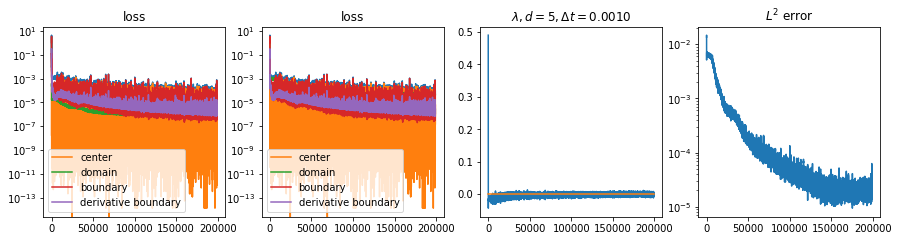

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))

ax[0].plot(loss_log)
ax[0].plot(loss_log_center, label='center')
ax[0].plot(loss_log_domain, label='domain')
ax[0].plot(loss_log_boundary, label='boundary')
ax[0].plot(loss_log_derivative_boundary, label='derivative boundary')
ax[0].legend()
ax[0].set_yscale('log');
ax[0].set_title('loss')
ax[1].plot(loss_log)
ax[1].plot(np.array(loss_log_center), label='center')
ax[1].plot(alpha[0] * np.array(loss_log_domain), label='domain')
ax[1].plot(alpha[1] * np.array(loss_log_boundary), label='boundary')
ax[1].plot(alpha[1] * np.array(loss_log_derivative_boundary), label='derivative boundary')
ax[1].legend()
ax[1].set_yscale('log');
ax[1].set_title('loss')
ax[2].plot(lambda_log)
ax[2].plot([0, len(lambda_log)], [problem.lambda_, problem.lambda_]);
ax[2].set_title(r'$\lambda, d = %d, \Delta t = %.4f$' % (problem.d, delta_t));
ax[3].plot(V_L2_log)
ax[3].set_yscale('log');
ax[3].set_title(r'$L^2$ error');

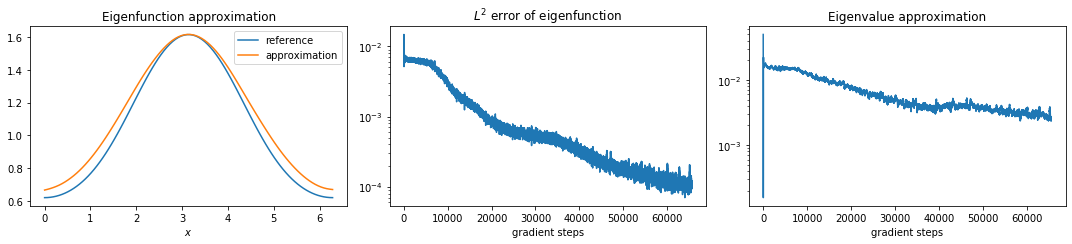

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3.5))

ax[0].set_title(r'Eigenfunction approximation')
X = pt.linspace(0, 2 * np.pi, 100).unsqueeze(1).repeat(1, problem.d).to(device)
ax[0].plot(X[:, 0].squeeze().cpu().numpy(), problem.v_true(X.cpu()).numpy(), label='reference')
ax[0].plot(X[:, 0].squeeze().detach().cpu().numpy(), (V(X).squeeze().detach().cpu().numpy()), label='approximation');
ax[0].set_xlabel(r'$x$')
ax[0].legend()

ax[1].plot(V_L2_log)
ax[1].set_yscale('log');
ax[1].set_title(r'$L^2$ error of eigenfunction');
ax[1].set_xlabel('gradient steps')

ax[2].set_title('Eigenvalue approximation')
ax[2].plot([np.abs(np.mean(lambda_log[i:i + 200])) for i in range(len(lambda_log) - 200)])
ax[2].set_yscale('log')
ax[2].set_xlabel('gradient steps')

#ax[2].set_title('Relative error of Eigenvalue')
#ax[2].plot([np.abs(problem.lambda_ - np.mean(lambda_log[i:i + 1000])) / (1 + problem.lambda_) for i in range(len(lambda_log) - 1000)])
#ax[2].set_yscale('log')
#ax[2].plot([0, len(lambda_log)], [problem.lambda_, problem.lambda_]);

fig.tight_layout()
#fig.savefig('img/Fokker-Planck-eigenvalue-d5_2.pdf')